In [1]:
!pip install tensorflow transformers

In [2]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
import subprocess
subprocess.check_call(['pip', 'install', '-q', 'tf_keras'])

0

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from transformers import TFViTForImageClassification, ViTImageProcessor
import os

2025-12-06 09:42:37.993748: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765014158.015971    1344 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765014158.022790    1344 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 224  
NUM_CLASSES = 10  
LEARNING_RATE = 5e-5 
EPOCHS = 4

In [5]:
import shutil
import os

ORIGINAL_DIR = '/kaggle/input/eurosat-dataset/EuroSAT' 


DATA_DIR = '/kaggle/working/EuroSAT_Clean'

if os.path.exists(DATA_DIR):
    shutil.rmtree(DATA_DIR)

print(f"Copying data from {ORIGINAL_DIR} to {DATA_DIR}...")

def ignore_junk(directory, files):
    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tif', '.tiff'}
    ignored = []
    for f in files:
        if os.path.isdir(os.path.join(directory, f)):
            if f.startswith('.'):
                ignored.append(f)
            continue
        
        ext = os.path.splitext(f)[1].lower()
        if f.startswith('.') or ext not in valid_extensions:
            ignored.append(f)
    return set(ignored)

shutil.copytree(ORIGINAL_DIR, DATA_DIR, ignore=ignore_junk)

print("Done")
print(f"Update your DATA_DIR variable to: {DATA_DIR}")

Copying data from /kaggle/input/eurosat-dataset/EuroSAT to /kaggle/working/EuroSAT_Clean...
Done
Update your DATA_DIR variable to: /kaggle/working/EuroSAT_Clean


In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(factor=0.2, fill_mode='reflect'),
    layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), fill_mode='reflect'),
    layers.RandomContrast(factor=0.1)
])

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

def preprocess_data(images, labels):
    images = (images / 127.5) - 1.0
    images = tf.transpose(images, perm=[0, 3, 1, 2])
    return {"pixel_values": images}, labels

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

train_ds = train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='int'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='int'
)

Found 27000 files belonging to 10 classes.
Using 21600 files for training.


I0000 00:00:1765014319.989767    1344 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 27000 files belonging to 10 classes.
Using 5400 files for validation.


In [7]:
feature_extractor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

In [8]:
def preprocess_data(images, labels):
    # 1. Force valid float32 type (Prevents TypeErrors)
    images = tf.cast(images, tf.float32)
    
    # 2. Normalize to [-1, 1]
    images = (images / 127.5) - 1.0
    
    # 3. CRITICAL FIX: Transpose from (Batch, H, W, C) to (Batch, C, H, W)
    # Hugging Face ViT expects channels to be the second dimension
    images = tf.transpose(images, perm=[0, 3, 1, 2])
    
    return {"pixel_values": images}, labels

In [9]:
train_ds = train_ds.map(preprocess_data).shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess_data).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
model = TFViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels=NUM_CLASSES,
    id2label={str(i): f"Class {i}" for i in range(NUM_CLASSES)},
    label2id={f"Class {i}": i for i in range(NUM_CLASSES)},
    
    # ADD THIS LINE:
    ignore_mismatched_sizes=True 
)

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFViTForImageClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageCla

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

print("Starting Training...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Starting Training...
Epoch 1/4


I0000 00:00:1765014361.164033    1411 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1765014362.314449    1410 service.cc:148] XLA service 0x79946803c0e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765014362.314500    1410 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1765014362.424536    1410 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


675/675 [==============================] - 573s 774ms/step - loss: 0.1493 - accuracy: 0.9576 - val_loss: 0.0741 - val_accuracy: 0.9791
Epoch 2/4
675/675 [==============================] - 531s 769ms/step - loss: 0.0391 - accuracy: 0.9875 - val_loss: 0.0780 - val_accuracy: 0.9776
Epoch 3/4
675/675 [==============================] - 531s 769ms/step - loss: 0.0192 - accuracy: 0.9940 - val_loss: 0.0561 - val_accuracy: 0.9848
Epoch 4/4
675/675 [==============================] - 531s 769ms/step - loss: 0.0210 - accuracy: 0.9934 - val_loss: 0.0779 - val_accuracy: 0.9791


In [12]:
import shutil
import os
from IPython.display import FileLink

MODEL_DIR = '/kaggle/working/'
OUTPUT_ZIP_NAME = 'model_final'

# Check if the model folder exists first
if os.path.exists(MODEL_DIR):
    print(f"Zipping {MODEL_DIR}...")
    # This creates 'eurosat_vit_model_final.zip'
    shutil.make_archive(OUTPUT_ZIP_NAME, 'zip', MODEL_DIR)
    print("Zipping complete!")
    
    # Generate a clickable download link
    print("\nClick the link below to download your model:")
    display(FileLink(f'{OUTPUT_ZIP_NAME}.zip'))
else:
    print(f"Error: Could not find folder '{MODEL_DIR}'. Did you run model.save_pretrained()?")

Zipping /kaggle/working/...
Zipping complete!

Click the link below to download your model:


/kaggle/working/model_final.zip

Scanning 2816x1536 image with box size 250...


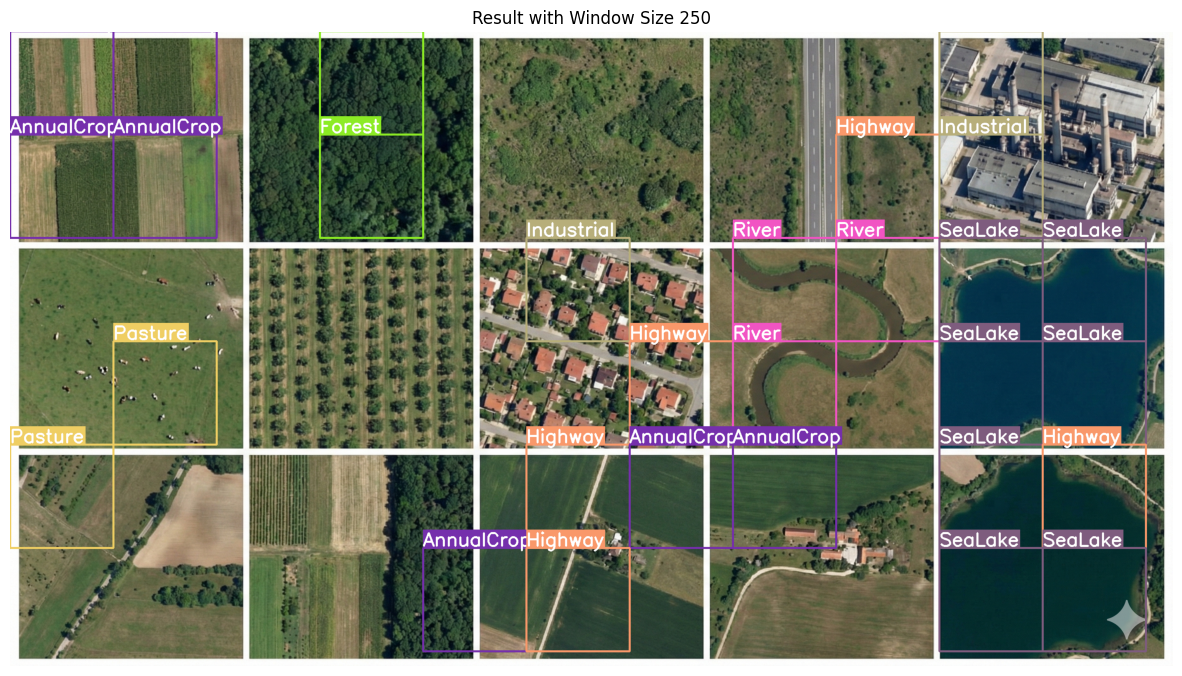

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# ==========================================
# CONFIGURATION
# ==========================================
# 1. ADJUST THIS TO "ZOOM" IN OR OUT
# Larger number = Bigger Box = More Context (Better for Highways)
WINDOW_SIZE = 250  

# 2. STRIDE (How much to move the box each step)
# Keep this close to WINDOW_SIZE to avoid overlapping boxes
STRIDE = 250 

# Load model if needed
if 'model' not in globals():
    from transformers import TFViTForImageClassification
    model = TFViTForImageClassification.from_pretrained("./eurosat_vit_model")

labels_map = {
    0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation',
    3: 'Highway', 4: 'Industrial', 5: 'Pasture',
    6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'
}

def predict_large_image_zoomed(image_path):
    # Read Image
    img = cv2.imread(image_path)
    if img is None: return print("Error: Image not found.")
    
    # Convert for display
    img_display = img.copy()
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    h, w, _ = img.shape
    print(f"Scanning {w}x{h} image with box size {WINDOW_SIZE}...")

    # Loop with larger steps
    for y in range(0, h - WINDOW_SIZE + 1, STRIDE):
        for x in range(0, w - WINDOW_SIZE + 1, STRIDE):
            
            # 1. CUT A LARGE CHUNK (The "Context")
            patch = img_rgb[y:y+WINDOW_SIZE, x:x+WINDOW_SIZE]
            
            # 2. RESIZE to 224x224 (What the model expects)
            # This compresses the big view into the model's input size
            patch_resized = cv2.resize(patch, (224, 224))
            
            # 3. Normalize & Shape
            patch_norm = (patch_resized / 127.5) - 1.0
            patch_input = np.transpose(patch_norm, (2, 0, 1))
            patch_input = np.expand_dims(patch_input, axis=0)
            
            # 4. Predict
            outputs = model.predict({"pixel_values": patch_input}, verbose=0)
            probs = tf.nn.softmax(outputs.logits, axis=-1)
            confidence = np.max(probs)
            predicted_class = int(np.argmax(probs))
            label_text = labels_map[predicted_class]

            # 5. DRAW ONLY IF CONFIDENT
            if confidence > 0.80:
                # Pick a color based on class ID
                np.random.seed(predicted_class)
                color = tuple(np.random.randint(0, 255, 3).tolist())
                
                # Draw THICK box
                cv2.rectangle(img_display, (x, y), (x+WINDOW_SIZE, y+WINDOW_SIZE), color, 4)
                
                # Draw Large Readable Label
                font_scale = 1.5  # Bigger text
                thickness = 3
                (text_w, text_h), _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)
                
                # Text Background
                cv2.rectangle(img_display, (x, y - text_h - 10), (x + text_w, y), color, -1)
                
                # Text
                cv2.putText(img_display, label_text, (x, y - 5), 
                            cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), thickness)

    return img_display


result = predict_large_image_zoomed("/kaggle/input/all-type/Gemini_Generated_Image_qhmh1vqhmh1vqhmh.png")

if result is not None:
    plt.figure(figsize=(15, 15))
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Result with Window Size {WINDOW_SIZE}")
    plt.show()